#### TWB Comparison PRISM, ERA5 and CONUS404
PRISM TWB is calculated from PRISM temperature and dewpoint, and pressure from ERA5

#### 1) extract hourly timeseries of ERA5 and WRFCONUS at Yuma AZ
 - 1.1) get lat-lon of Yuma, AZ usging geolocator
 - 1.2) get index (i, j) of Yuma in WRF CONUS404 (unstructured RCM grid)
 - 1.3) extract hourly data time series from unstructured grid WRF CONUS404
 - 1.4) extract hourly data time series of ERA5 over Yuma, AZ (structual grid) 
 
#### 2) mash plot days > 90 percentile.
#### 3) output the date of  > 90 percentile
#### 4) Line plot of the 50,75, 90, 95, 99, 99.9 TWB percentiles for each dataset so we can see how the differences change with rarity of the event. 
-4b) average diurnal cycle for CONUS404 and ERA5 in Aug
#### 5) Compute observation (PRISM) 
 - 5.1) read PRISM T2, Tmean (i,j) at Yuma
 - 5.2.1) extract TD daily data time series from unstructured grid PRISM
 - 5.2.2) extract T2 daily data time series from unstructured grid PRISM
 - 5.2.3) get pressure i,j from ERA5
 - 5.3) calculate observational daily TWB
  
#### 6)Comarison ERA5, WRFCONUS404 vs. PRISM 
 - 6.1) resample ERA5, WRFCONUS404 hourly data to daily data
 - 6.2) timeseries plots of annual number of days > 90th percentile
 - 6.3)  timeseries plots of annual max TWB.  
 

In [1]:
import os.path
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime
import geopy
import scipy
from scipy.interpolate import griddata
from geopy.geocoders import Nominatim
from metpy.calc import wet_bulb_temperature
from metpy.units import units

In [72]:
def find_indices(points,lon,lat,tree=None):
    if tree is None:
        lon,lat = lon.T,lat.T
        lonlat = np.column_stack((lon.ravel(),lat.ravel()))
        tree = scipy.spatial.cKDTree(lonlat)
    dist,idx = tree.query(points,k=1)
    ind = np.column_stack(np.unravel_index(idx,lon.shape))
    return [(i,j) for i,j in ind]

def cal_p90_df(flnm):
    '''
    flnm: input hourly time series file name
    return P90 of daily maximum and daily maximum timeseries   
    '''
    df = pd.read_csv(flnm, index_col = 0)
    
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
        
    # resample hourly data to daily data
    df_dmax = df.resample('D').max()
    
    # calculate quantile over requested axis
    p90_tmax = df_dmax.quantile(.9, axis = 0)
     
    return p90_tmax, df_dmax

####

def cal_qs(flnm, q_1d, method):
    '''
    flnm: input hourly time series file name
    q_1d: quantile array
    return  percentiles of daily maximum    
    '''
    print(flnm)
    
    n_q = len(q_1d)
    p_1d = np.zeros(n_q)
    
    df = pd.read_csv(flnm, index_col = 0)
    
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
        
    # resample hourly data to daily data
    if method == 'mean':
        df_dmax = df.resample('D').mean()
    elif method == 'max':
        df_dmax = df.resample('D').max()
    elif method == 'min':
        df_dmax = df.resample('D').min()
        
    ct = 0
    for nq in q_1d:
        # calculate quantile over requested axis
        p_1d[ct] = df_dmax.quantile(nq, axis = 0)
        ct = ct + 1
        
    return p_1d

def plot_xy2(q_1d, p_2d, method, x_title):
    fig, ax = plt.subplots()

    ax.plot(q_1d, p_2d[0],label = "CONUS404", linestyle="-", linewidth=2.0)
    ax.plot(q_1d, p_2d[1],label = "ERA5", linestyle="-", linewidth=2.0)

    #plt.title('My title')
    plt.xlabel(x_title)
    plt.ylabel('TWB(C) ' + method)
    plt.legend()
    plt.show()

def mask_perc(df, column, perc):
    '''
    mask column of dataFram df with values less than perc
    df: dataFrame
    column: the column to mask
    perc:  percentile value
    '''
    itt = df.index[df[column] < perc]
    # Make a copy of this object’s indices and data.
    # deep=True (default)
    ts_series = df[column].copy()
    ts_series[itt] = np.nan
    return ts_series

#### setup

In [3]:
dir_c = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/TWB/'
dir_e = '/glade/campaign/mmm/c3we/wetbulb/'
dir_o = '/glade/campaign/mmm/c3we/mingge/DOD/'

year_s = 1980
year_e = 2020
 
n_year = year_e - year_s + 1
n_366 = 366

StartDay = datetime.datetime(year_s, 1, 1, 0)
StopDay  = datetime.datetime(year_e, 12, 31, 23)
TimeHH   = pd.date_range(StartDay, end=StopDay, freq='1h')
 
print('n_hours:', len(TimeHH), ' between', StartDay, 'and', StopDay)

n_hours: 359424  between 1980-01-01 00:00:00 and 2020-12-31 23:00:00


#### 1.1) get lat-lon of Yuma, AZ usging geolocator

In [4]:
# Create a geolocator object using the Openstreet Nominatim API. 
# It’s a good idea to increase the default timeout setting from 1s to 10s 
# so that you don’t get a TimedOut exception. 
# You’ll also need to enter a name (any name) for the ‘user_agent’ attribute.
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
#loc = geolocator.geocode('Yuma' + ','+ 'US')
loc = geolocator.geocode('Yuma, US')
lat_pt = loc.latitude
lon_pt = loc.longitude

points = ([[lon_pt, lat_pt]])

#points = np.array([lon_pt, lat_pt]).transpose() 
print(points)

[[-114.47603157249804, 32.665135]]


#### 1.2) get index (i, j) of Yuma in WRF CONUS404 (unstructured RCM grid)

In [6]:
# a test
flnm_c =  dir_c + 'TWB_202012_CONUS404.nc' 
print(flnm_c)

with  xr.open_dataset(flnm_c) as ds:
    Lat = ds.lat.to_numpy()
    Lon = ds.lon.to_numpy()  
     
    ind = find_indices(points, Lon, Lat,tree=None)[0]
    print('model Lon-Lat', Lon[ind[1],ind[0]], Lat[ind[1],ind[0]], 'vs actual lon_lat', points)

/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/TWB/TWB_202012_CONUS404.nc
model Lon-Lat -114.47633 32.65857 vs actual lon_lat [[-114.47603157249804, 32.665135]]


#### 1.3) extract hourly data time series from  unstructured grid WRF CONUS404 

In [7]:
flnm_ow = dir_o + 'twb_yuma_conus404_hourly.csv'

if os.path.exists(flnm_ow): 
    print(flnm_ow, 'exist')
    df_w = pd.read_csv(flnm_ow, index_col = 0)    
else:       
    for year in range(year_s, year_e + 1):
        for month in range(1,12+1):
            flnm = dir_c + 'TWB_' + str(year) + str(month).zfill(2) + '_CONUS404.nc' 
        
            with xr.open_dataset(flnm) as ds:
                print('FILE=', flnm)                
                var = ds['TWB'][:, ind[1],ind[0] ]
            if year == year_s and month == 1:
                var_new = var
            else:
                var_new = np.append(var_new, var, axis=0)
            
    df = pd.DataFrame(var_new, index = TimeHH,  columns = ['Yuma'])
 
    print(flnm_ow)
    df.to_csv(flnm_ow)  
    print('SUCCEED')  

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly.csv exist


#### 1.4) extract hourly data time series of ERA5 over Yuma, AZ (structual grid) 

In [8]:
flnm_oe = dir_o + 'twb_yuma_era_hourly.csv'
print(flnm_oe)
if os.path.exists(flnm_oe): 
    print(flnm_oe, 'exist')
    df_e = pd.read_csv(flnm_oe, index_col = 0)  
else:       
    for year in range(year_s, year_e + 1):
        for month in range(1,12+1):
            flnm_e = dir_e + 'TWB_' + str(year) + str(month).zfill(2) + '.nc' 
            with xr.open_dataset(flnm_e) as ds:
                print('FILE=', flnm_e)                
                var = ds['TWB'].sel(latitude=lat_pt, longitude=lon_pt+360, method="nearest").values
            if year == year_s and month == 1:
                var_new = var
            else:
                var_new = np.append(var_new, var, axis=0)
            
    df = pd.DataFrame(var_new, index = TimeHH,  columns = ['Yuma'])
 
    print(flnm_oe)
    df.to_csv(flnm_oe)  
    print('SUCCEED')  

#df_e.plot(title='Yuma')

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_hourly.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_hourly.csv exist


#### 2) Calculate and plot days > 90 percentile.

In [9]:
n_366 = 366
arr_2d = np.empty((n_year, n_366))
arr_2d[:] = np.nan

# the outputs of meshgrid are of shape (N, M) for ‘xy’ indexing and (M, N) for ‘ij’ indexing.
# default 'xy' indexing
day_2d, year_2d = np.meshgrid(range(1, n_366+1), range(year_s, year_e+1))

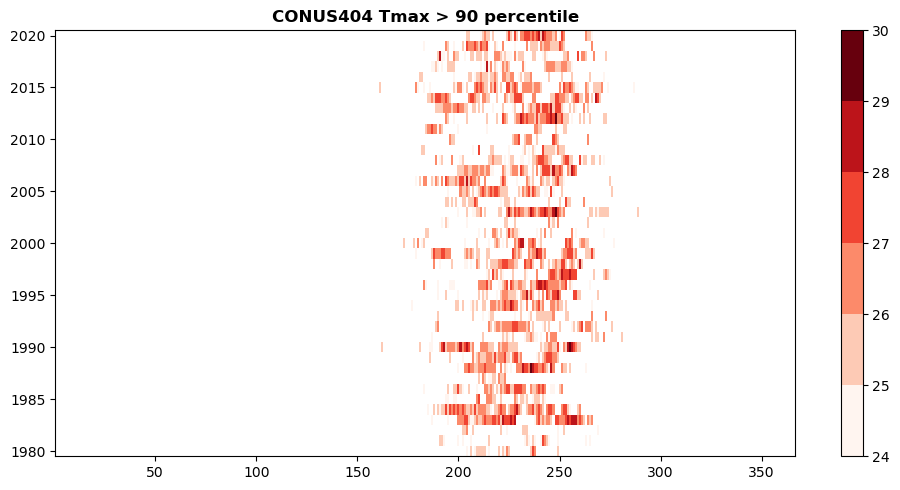

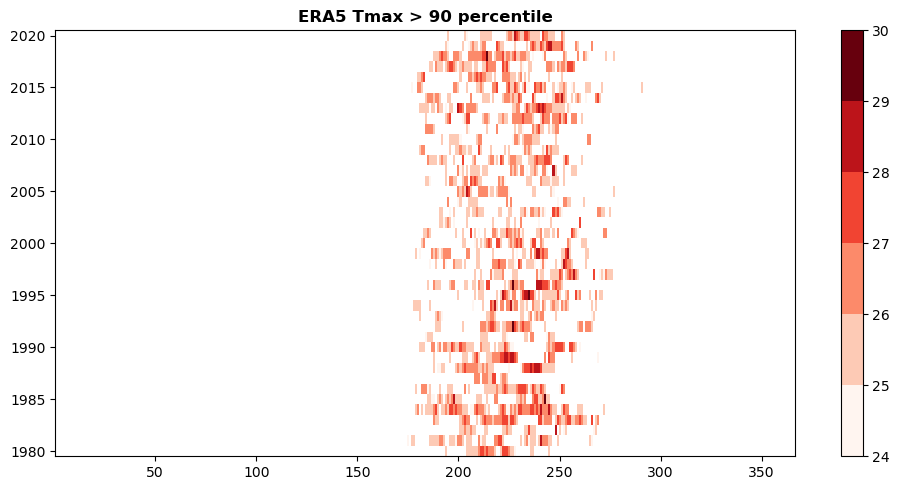

In [10]:
flnm_1d = [flnm_ow, flnm_oe]
title_1d = ['CONUS404', 'ERA5']

nn = 0
for flnm in flnm_1d:
    fig, ax = plt.subplots(1,1,figsize=(10, 5)) 
    p90_tmax, df_dmax = cal_p90_df(flnm)
    
    # mask <90 percentile data 
    data = {'year': pd.DatetimeIndex(df_dmax.index).year,
            'Yuma': mask_perc(df_dmax, 'Yuma', p90_tmax['Yuma'])}
    
    df_new = pd.DataFrame(data)
    
    for year in range(year_s, year_e+1):
        iTT = np.isin(df_new.year, year)
        # by adding [0] in id_iTT, convert tuple -> numpy.ndarray
        id_iTT = np.where(iTT == True)[0] 
         
        arr_2d[year-year_s, :len(id_iTT)] = df_new['Yuma'][id_iTT]  
            
    # WRF CONUS404 K->C
    if nn == 0 :
        arr_2d = arr_2d - 273.15
        
    # the pcolormesh() method to create a pseudocolor plot with a non-regular rectangular grid.
    # use the plt.cm.get_cmap() for discret color bars
    im = ax.pcolormesh(day_2d, year_2d, arr_2d, vmin = 24, vmax = 30, cmap=plt.cm.get_cmap('Reds', 6)) 
    cbar = fig.colorbar(im, ax=ax)
    ax.set_title(title_1d[nn] + ' Tmax > 90 percentile', fontweight ="bold")
    nn = nn + 1    
    plt.tight_layout()     

#### 3) output the date of > 90 percentile

In [11]:
flnm_1d = [flnm_ow, flnm_oe]
flnm_o = [dir_o + 'twb_yuma_conus404_p90.csv', dir_o + 'twb_yuma_era_p90.csv']

ct = 0
for flnm in flnm_1d:
    p90_tmax, df_dmax = cal_p90_df(flnm) 
    
    df = pd.read_csv(flnm, index_col = 0)
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
        
    # resample hourly data to daily data
    df_dmax = df.resample('D').max()
 
    df = df_dmax[df_dmax['Yuma'] > p90_tmax.values[0]]
    df.to_csv(flnm_o[ct])

    print(flnm_o[ct], p90_tmax.values[0] )
    ct = ct + 1
    
print('SUCCEED') 
     

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_p90.csv 297.85498
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_p90.csv 24.866211
SUCCEED


 #### 4) Line plot of the 50,75, 90, 95, 99, 99.9 TWB(max)  

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_hourly.csv


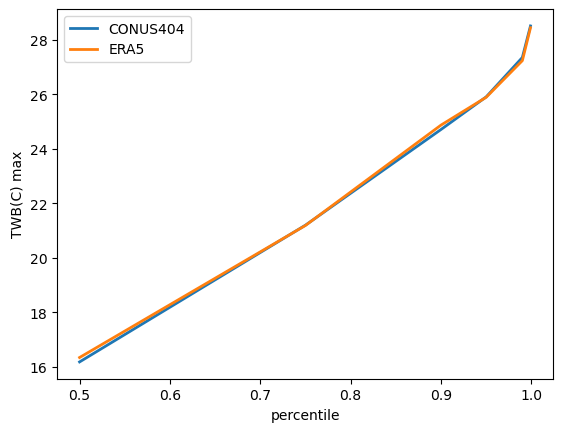

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_hourly.csv


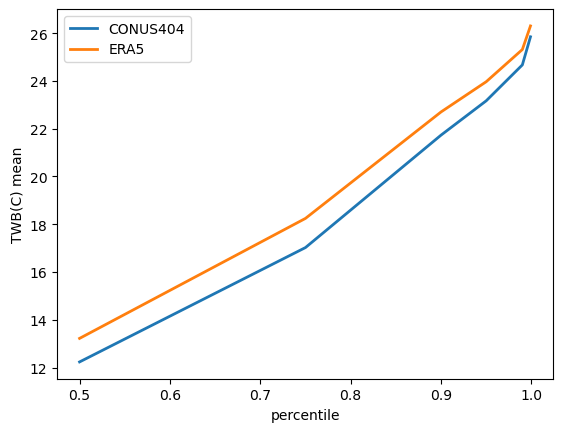

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_hourly.csv


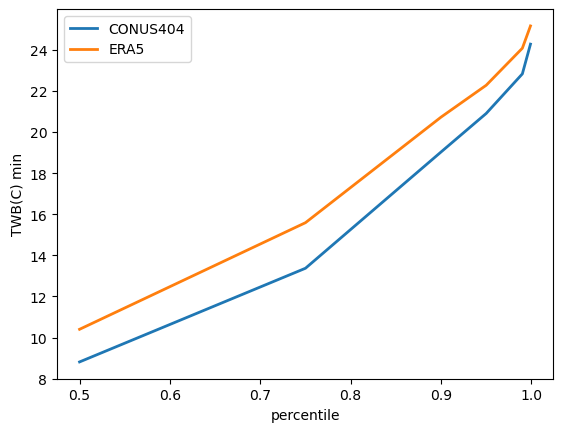

In [73]:
q_1d = [.50, .75, .90, .95, .99, .999]
n_q = len(q_1d)
p_2d = np.zeros((2, n_q))

method_1d = ['max', 'mean', 'min']

for method in method_1d:
    ct = 0
    for flnm in flnm_1d:
        p_2d[ct] = cal_qs(flnm, q_1d, method)
        if ct == 0:
            p_2d[ct] = p_2d[ct] - 273.15
            ct = ct + 1
    # plot
    plot_xy2(q_1d, p_2d, method, 'percentile')   

#### 4b) average diurnal cycle for CONUS404 and ERA5 in Aug
(hourly data)? Maybe we can define the average using all values for August for all years.

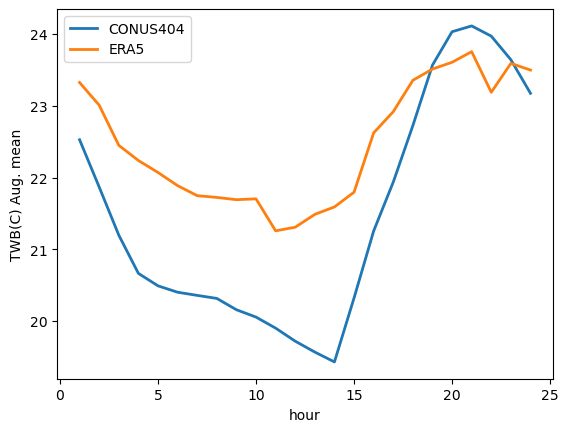

In [74]:
flnm_1d = [flnm_ow, flnm_oe]
title_1d = ['CONUS404', 'ERA5']
Tdiurnal_2d = np.zeros((2, 24))

nn = 0
for flnm in flnm_1d:
    df = pd.read_csv(flnm, index_col = 0)
    #print(df)
    
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
    df['hour'] = df.index.hour    
    df['month'] =  df.index.month
     
    ind_m = df.groupby('month').get_group((8)).index
    df_m =  df.loc[ind_m]
    df_h =  df_m.groupby('hour').mean()
    #print(ind_m)
    #print(df_m)
    if nn == 0:
        Tdiurnal_2d[nn]= df_h['Yuma'] - 273.15
    else:
        Tdiurnal_2d[nn]= df_h['Yuma']
    nn = nn +1
plot_xy2(range(1,25),  Tdiurnal_2d, 'Aug. mean', 'hour')

In [ ]:
df['hour'] = pd.Categorical(df['timestamp'].dt.hour, categories=range(24))
df1 = df.groupby(['id','imo','hour']).median().reset_index()

#### 5 to compare with an observation.
Observational TWB is calculated from PRISM (TD, T) and ERA5 (SLP)
- 5.1) read PRISM (i,j) at Yuma

In [12]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'
dir_td = dir_prism + 'TDmean/'
dir_t2 = dir_prism + 'T2M/'

year_s = 1981
StartDay = datetime.datetime(year_s, 1, 1, 0)
StopDay  = datetime.datetime(year_e, 12, 31, 23)
 
TimeDD   = pd.date_range(StartDay, end=StopDay, freq='1d')

In [13]:
flnm_td =  dir_td + 'PRISM_daily_tdmean_1990.nc' 
 
with  xr.open_dataset(flnm_td) as ds:
    Lat = ds.lat.to_numpy()
    Lon = ds.lon.to_numpy()   
    ind = find_indices(points, Lon, Lat,tree=None)[0]
    print('model Lon-Lat', Lon[ind[1],ind[0]], Lat[ind[1],ind[0]], 'vs actual lon_lat', points)

model Lon-Lat -114.458336 32.666668 vs actual lon_lat [[-114.47603157249804, 32.665135]]


- 5.2.1)  extract TD daily data time series from unstructured grid PRISM

In [14]:
flnm_ow = dir_o + 'td_yuma_prism_daily.csv'

if os.path.exists(flnm_ow): 
    print(flnm_ow, 'exist')
    df_w = pd.read_csv(flnm_ow, index_col = 0)    
else:       
    for year in range(year_s, year_e + 1):
        flnm = dir_td + 'PRISM_daily_tdmean_' + str(year) + '.nc' 
        with xr.open_dataset(flnm) as ds:
            print('FILE=', flnm)                
            var = ds['TDmean'][:, ind[1],ind[0] ]
            if year == year_s:
                var_new = var
            else:
                var_new = np.append(var_new, var, axis=0)
            
    df = pd.DataFrame(var_new, index = TimeDD,  columns = ['Yuma'])
 
    print(flnm_ow)
    df.to_csv(flnm_ow)  
    print('SUCCEED')  
     

/glade/campaign/mmm/c3we/mingge/DOD/td_yuma_prism_daily.csv exist


- 5.2.2) T2 extract daily data time series from unstructured grid PRISM

In [15]:
flnm_ow = dir_o + 't2_yuma_prism_daily.csv'

if os.path.exists(flnm_ow): 
    print(flnm_ow, 'exist')
    df_w = pd.read_csv(flnm_ow, index_col = 0)    
else:       
    for year in range(year_s, year_e + 1):
        flnm = dir_t2 + 'PRISM_daily_tmean_' + str(year) + '.nc' 
        with xr.open_dataset(flnm) as ds:
            print('FILE=', flnm)                
            var = ds['T2M'][:, ind[1],ind[0] ]
            if year == year_s:
                var_new = var
            else:
                var_new = np.append(var_new, var, axis=0)
            
    df = pd.DataFrame(var_new, index = TimeDD,  columns = ['Yuma'])
 
    print(flnm_ow)
    df.to_csv(flnm_ow)  
    print('SUCCEED')  

/glade/campaign/mmm/c3we/mingge/DOD/t2_yuma_prism_daily.csv exist


 - 5.2.3) get pressure i,j from ERA5

In [16]:
flnm_sfc = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/sfc_yuma_era5.csv'
print(flnm_sfc, 'from 1979 to 2018')

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/sfc_yuma_era5.csv from 1979 to 2018


 - 5.3) calculate observational daily TWB
 from PRISM T, TD, and ERA5: sfc

In [17]:
year3_s = 1981
year3_e = 2018

flnm_t2 = dir_o + 't2_yuma_prism_daily.csv' 
flnm_td = dir_o + 'td_yuma_prism_daily.csv'
 
ind_s = str(year3_s) + '-01-01'
ind_e = str(year3_e) + '-12-31'

df = pd.read_csv(flnm_t2, index_col = 0)
# Create DatetimeIndex by DataFrame.set_index
# in order to use 'resample'
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
t2_df = df.loc[ind_s:ind_e]


df = pd.read_csv(flnm_td, index_col = 0)
# Create DatetimeIndex by DataFrame.set_index
# in order to use 'resample'
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
td_df = df.loc[ind_s:ind_e]


df = pd.read_csv(flnm_sfc, index_col = 0)
# Create DatetimeIndex by DataFrame.set_index
# in order to use 'resample'
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
sfc_df = df.loc[ind_s:ind_e]

In [18]:
flnm_op = dir_o + 'twb_yuma_op_daily.csv'

if os.path.exists(flnm_op): 
    print(flnm_op, 'exist')
    twb_df = pd.read_csv(flnm_op, index_col = 0)    
else:
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wet_bulb_temperature.html
    twb_obs = wet_bulb_temperature(sfc_df.values * units.hPa, t2_df.values * units.degC, td_df.values * units.degC)
    twb_df = pd.DataFrame(twb_obs, columns=['Yuma'])  
    twb_df.index = sfc_df.index
    twb_df.to_csv(flnm_op)  
    print('SUCCEED')  

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_op_daily.csv exist


#### 6) Comarison ERA5, WRFCONUS404 vs. PRISM   

 - 6.1) resample ERA5, WRFCONUS404 hourly data to daily data

In [23]:
flnm_hourly = [ dir_o + 'twb_yuma_conus404_hourly.csv',  dir_o + 'twb_yuma_era_hourly.csv']
flnm_daily  = [ dir_o + 'twb_yuma_conus404_daily.csv',  dir_o + 'twb_yuma_era_daily.csv']

nn = 0
for flnm in flnm_hourly:
    print(flnm)
    df = pd.read_csv(flnm, index_col = 0)
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H')
        
    # resample hourly data to daily data
    df_0 = df.resample('D').mean().loc[ind_s:ind_e] 
    
    if nn == 0:
        df_0['Yuma'] = df_0['Yuma'] - 273.15
    
    print(flnm_daily[nn])
    df_0.to_csv(flnm_daily[nn]) 

    nn = nn + 1    

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_hourly.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_daily.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_hourly.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_daily.csv


- 5.4.2) timeseries plots of annual number of days > 90th percentile

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_daily.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_daily.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_op_daily.csv


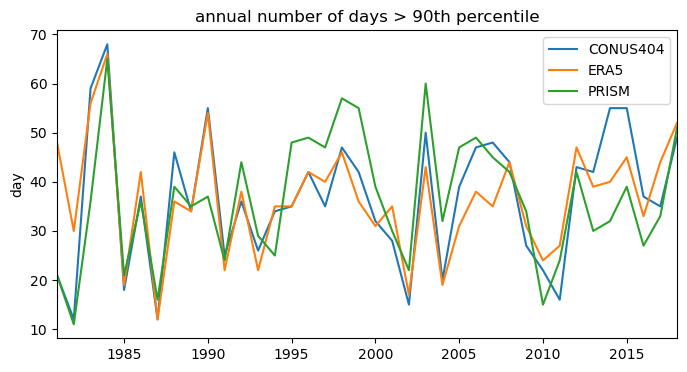

In [24]:
flnm_1d = [dir_o + 'twb_yuma_conus404_daily.csv',  
           dir_o + 'twb_yuma_era_daily.csv', 
           dir_o + 'twb_yuma_op_daily.csv']

title_1d = ['CONUS404', 'ERA5', 'PRISM']

p_2d = np.zeros((len(flnm_1d), year3_e - year3_s + 1))

nn = 0
for flnm in flnm_1d:
    print(flnm)
    df = pd.read_csv(flnm, index_col = 0)
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
                 
    # calculate quantile over requested axis
    p90_tmax = df.quantile(.9, axis = 0)
    
    # [0]: pandas Series.values returns Series as ndarray or ndarray-like
    itt = df.index[df['Yuma'] > p90_tmax.values[0]]
    #df_p = df.loc[itt]
    df_p = df.loc[itt].resample('Y').count()
    p_2d[nn] = df_p['Yuma']
     
    df_p.index = range(year3_s, year3_e+1)
    
    if nn == 0:
        df_p.rename(columns = {'Yuma':title_1d[nn]}, inplace = True)  
        twb_df = df_p.copy() 
    else:
        twb_df[title_1d[nn]] = df_p['Yuma']
    
    nn = nn + 1

twb_df.plot(figsize=(8,4), xlim=(year3_s, year3_e), ylabel='day'
            , title = 'annual number of days > 90th percentile'); 

 -  5.4.3) annual max TWB   

/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_conus404_daily.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_era_daily.csv
/glade/campaign/mmm/c3we/mingge/DOD/twb_yuma_op_daily.csv


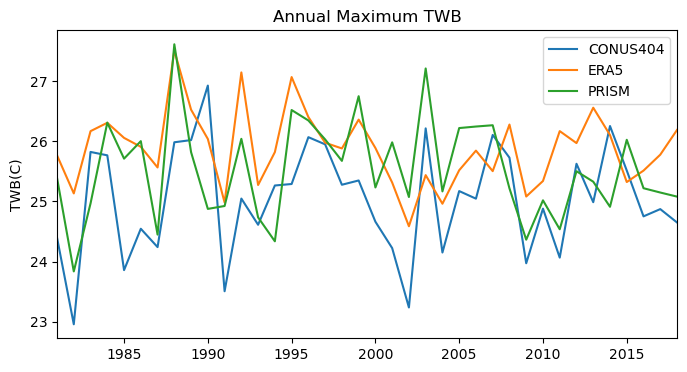

In [25]:
nn = 0
for flnm in flnm_1d:
    print(flnm)
    df = pd.read_csv(flnm, index_col = 0)
    # Create DatetimeIndex by DataFrame.set_index
    # in order to use 'resample'
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
                 
    df_p = df.resample('Y').max()
    p_2d[nn] = df_p['Yuma']
     
    df_p.index = range(year3_s, year3_e+1)
    
    if nn == 0:
        df_p.rename(columns = {'Yuma':title_1d[nn]}, inplace = True)  
        twb_df = df_p.copy() 
    else:
        twb_df[title_1d[nn]] = df_p['Yuma']
    
    nn = nn + 1

twb_df.plot(figsize=(8,4), xlim = (year3_s, year3_e), ylabel='TWB(C)'
           , title='Annual Maximum TWB');